# Import Libraries

In [3]:
import warnings
warnings.filterwarnings("ignore")

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# Data Loading

In [2]:
base_dir = 'input'
class_labels = os.listdir(base_dir)
class_labels.sort()

print(class_labels)

['Arson', 'Burglary', 'Explosion', 'Fighting', 'Normal']


In [3]:
chart_data=[]

for target in class_labels:
    path=os.path.join(base_dir,target)
    size=len(os.listdir(path))
    chart_data.append(size)
    print(f'The target {target} has ({size}) samples in the dataset')

The target Arson has (2216) samples in the dataset
The target Burglary has (1542) samples in the dataset
The target Explosion has (2075) samples in the dataset
The target Fighting has (1679) samples in the dataset
The target Normal has (1852) samples in the dataset


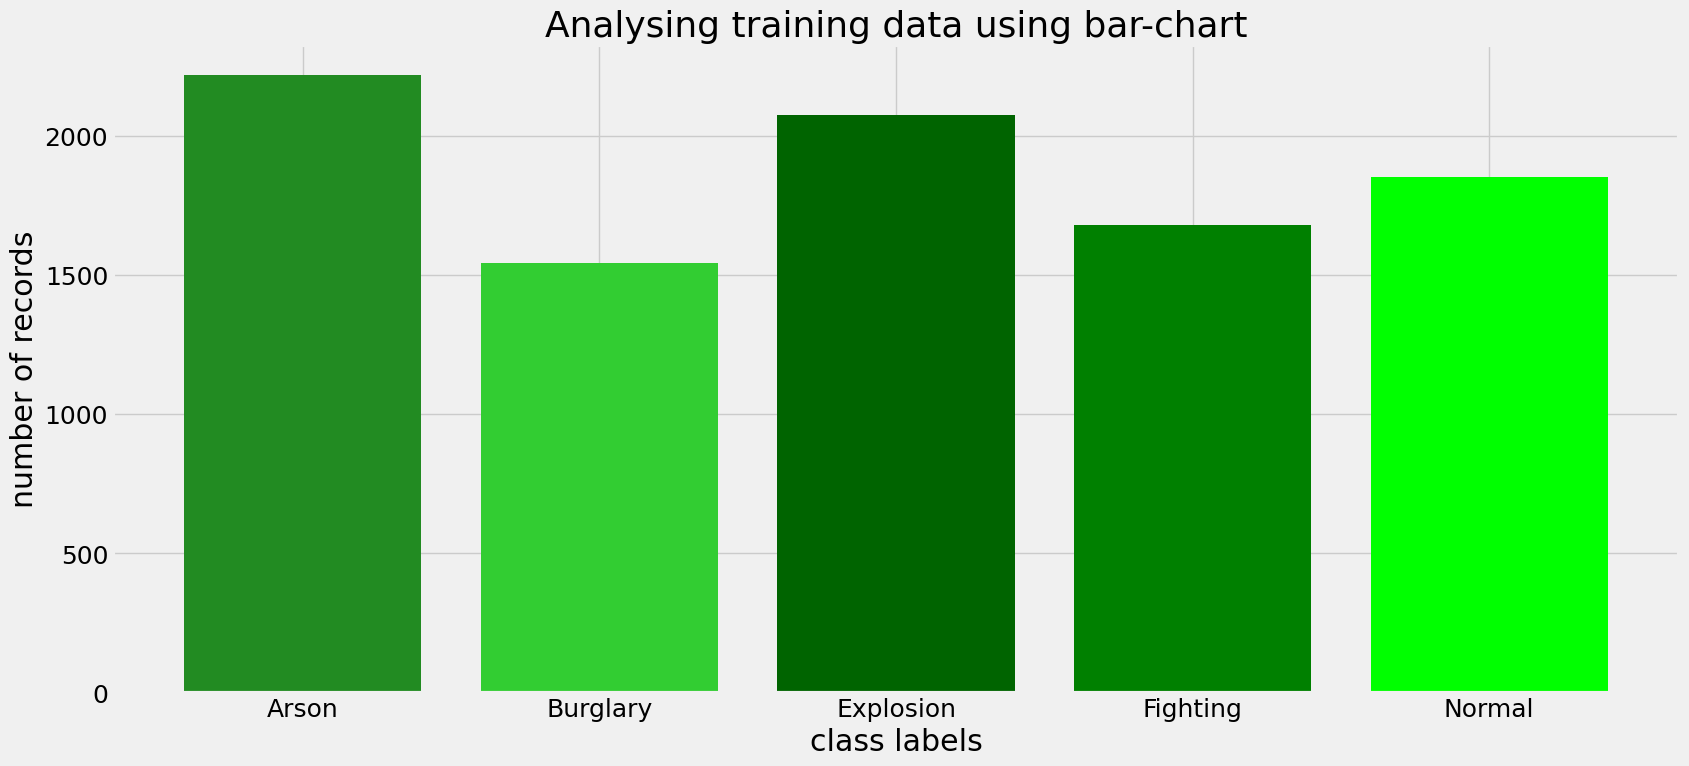

In [4]:
with plt.style.context(style="fivethirtyeight"):
    plt.figure(figsize=(18,8))
    plt.rcParams["font.size"]=18
    plt.bar(x=class_labels,
            height=chart_data,
            color=["forestgreen","limegreen","darkgreen","green","lime"])
    plt.title(label="Analysing training data using bar-chart")
    plt.xlabel(xlabel="class labels")
    plt.ylabel(ylabel="number of records")
    plt.show()

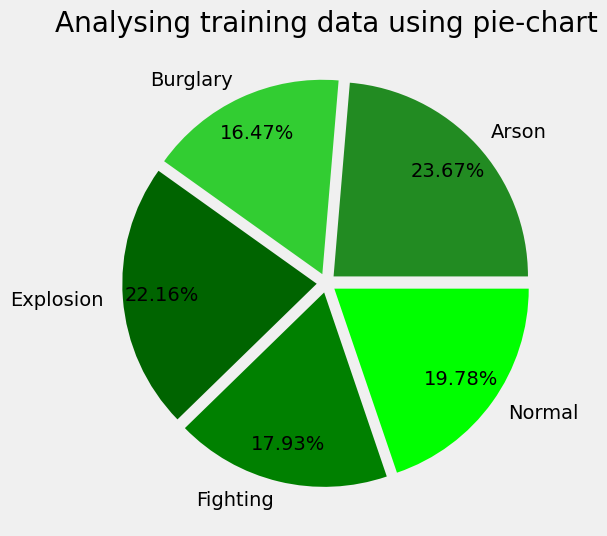

In [5]:
with plt.style.context(style="fivethirtyeight"):
    plt.figure(figsize=(6,6))
    plt.pie(x=chart_data,
        colors=["forestgreen","limegreen","darkgreen","green","lime","mediumseagreen"],
        labels=class_labels,
        autopct='%.2f%%',
        pctdistance=0.80,
        explode=[0.05]*len(class_labels))
    plt.title(label="Analysing training data using pie-chart")
    plt.show()

In [6]:
data = []
labels = []

for idx, target in enumerate(class_labels):
    path = os.path.join(base_dir, target)
    image_names = os.listdir(path)
    for image_name in tqdm(image_names, desc=f'Loading {target} images', total=len(image_names)):
        image_path = os.path.join(path, image_name)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (128,128))
        image = np.array(image)
        image = image/255.0
        data.append(image)
        labels.append(idx)

Loading Normal images: 100%|███████████████████████████████████████████████████████| 1852/1852 [04:41<00:00,  6.59it/s]


In [7]:
data = np.array(data)
labels = np.array(labels)

print(data.shape, labels.shape)

(9364, 128, 128, 3) (9364,)


In [8]:
def show_images(X, y, class_names):
    plt.figure(figsize=(10, 10))
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        idx = random.randint(0, X.shape[0]-1)
        plt.imshow(X[idx])
        plt.axis("off")
        plt.title("Class:{}".format(class_names[y[idx]]))
    plt.tight_layout()
    plt.show()

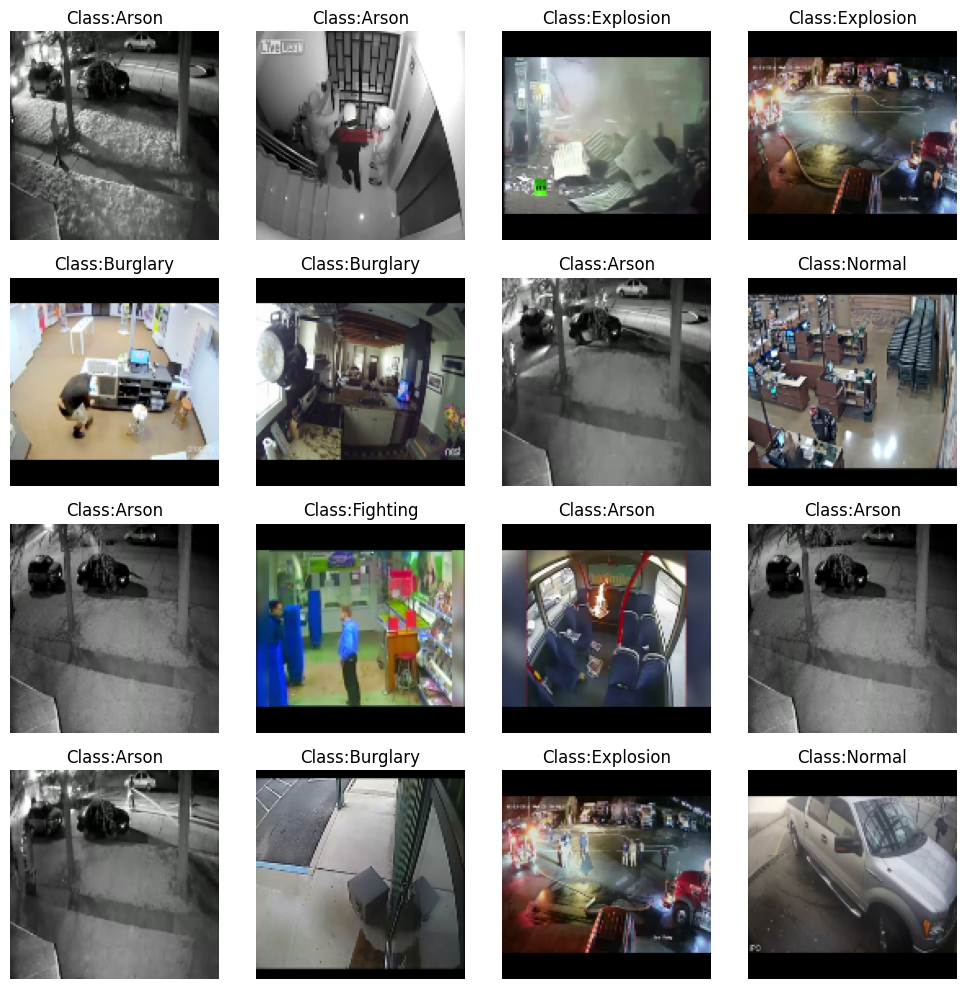

In [9]:
show_images(data, labels, class_labels)

In [13]:
labels = to_categorical(labels)
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=seed_value)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(7491, 128, 128, 3) (1873, 128, 128, 3) (7491, 5) (1873, 5)


---

# Algorithm: ConvolutionalNeuralNetwork

In [14]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, BatchNormalization, GlobalAveragePooling2D, Dense
from tensorflow.keras.regularizers import L1
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [15]:
model = Sequential()
model.add(Input((128, 128, 3)))
model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', kernel_regularizer=L1()))
model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', kernel_regularizer=L1()))
model.add(BatchNormalization())
model.add(MaxPool2D())
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', kernel_regularizer=L1()))
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', kernel_regularizer=L1()))
model.add(BatchNormalization())
model.add(MaxPool2D())
model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu', kernel_regularizer=L1()))
model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu', kernel_regularizer=L1()))
model.add(BatchNormalization())
model.add(MaxPool2D())
model.add(GlobalAveragePooling2D())
model.add(Dense(len(class_labels), activation='softmax'))

In [16]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 batch_normalization (Batch  (None, 128, 128, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        3

In [17]:
EPOCHS = 10

history = model.fit(
    x=data,
    y=labels,
    batch_size=32,
    epochs=EPOCHS,
    validation_data=(X_train, y_train),
    callbacks=[ReduceLROnPlateau(monitor='val_accuracy', patience=2, min_lr=0)]
)

Epoch 1/10
293/293 [==============================] - 30s 72ms/step - loss: 59.1419 - accuracy: 0.7235 - val_loss: 36.5403 - val_accuracy: 0.2366 - lr: 1.0000e-04
Epoch 2/10
293/293 [==============================] - 14s 49ms/step - loss: 22.0030 - accuracy: 0.8143 - val_loss: 13.5794 - val_accuracy: 0.2765 - lr: 1.0000e-04
Epoch 3/10
293/293 [==============================] - 14s 49ms/step - loss: 9.0329 - accuracy: 0.8209 - val_loss: 6.9604 - val_accuracy: 0.6011 - lr: 1.0000e-04
Epoch 4/10
293/293 [==============================] - 15s 50ms/step - loss: 5.4408 - accuracy: 0.8259 - val_loss: 4.7953 - val_accuracy: 0.7109 - lr: 1.0000e-04
Epoch 5/10
293/293 [==============================] - 15s 51ms/step - loss: 4.0640 - accuracy: 0.8306 - val_loss: 3.6338 - val_accuracy: 0.8255 - lr: 1.0000e-04
Epoch 6/10
293/293 [==============================] - 15s 52ms/step - loss: 3.3169 - accuracy: 0.8331 - val_loss: 3.1384 - val_accuracy: 0.7803 - lr: 1.0000e-04
Epoch 7/10
293/293 [==========

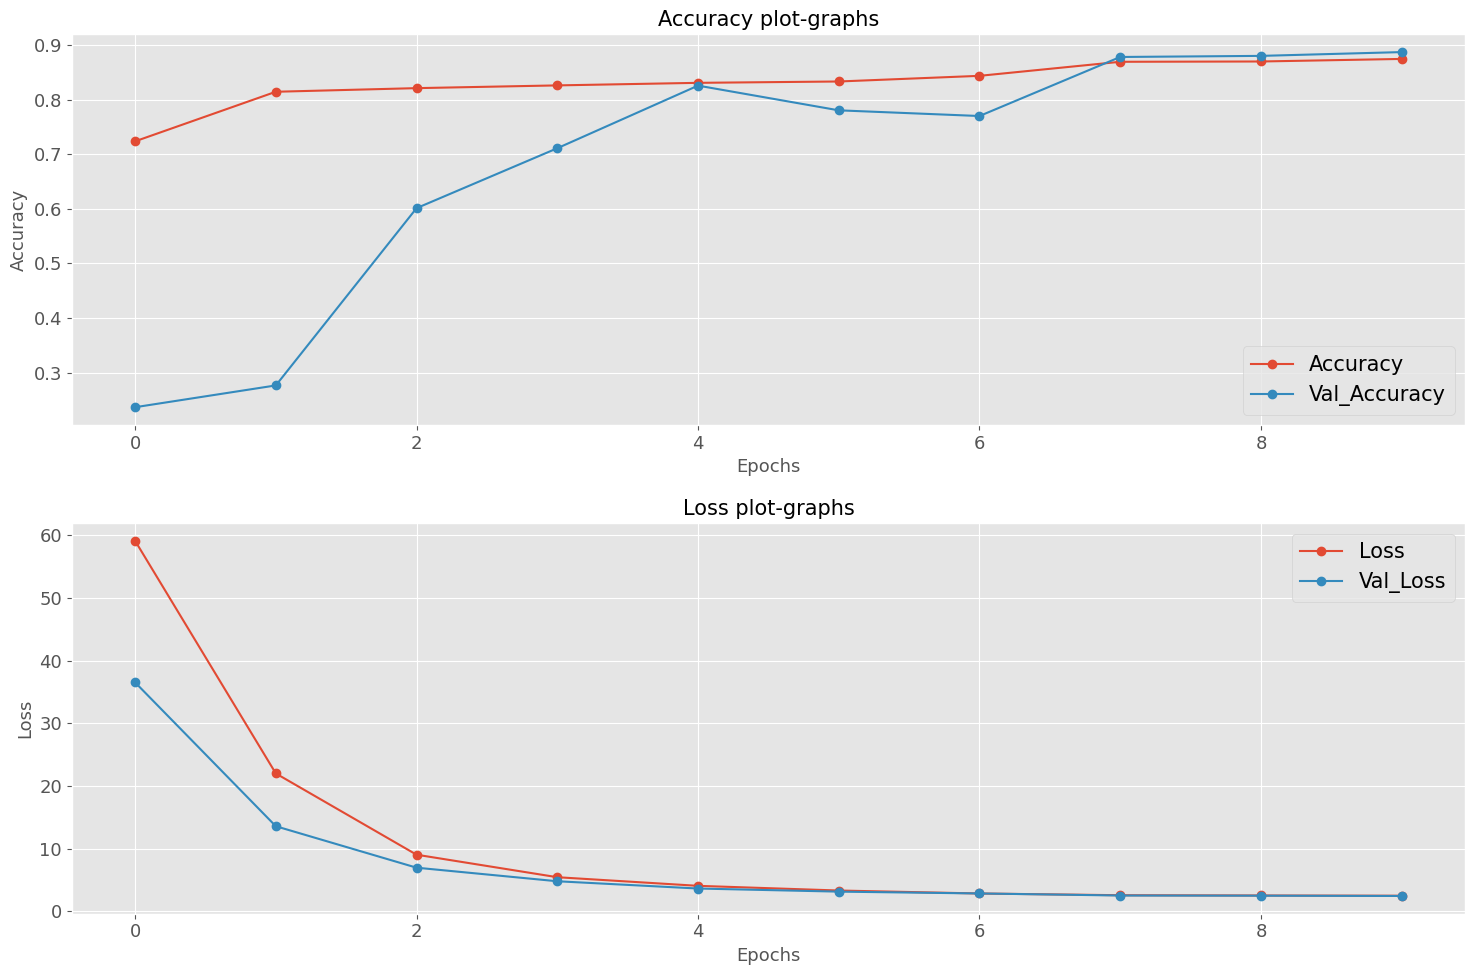

In [18]:
with plt.style.context(style="ggplot"):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))
    plt.rcParams["font.size"] = 15

    axes[0].plot(history.history['accuracy'], label='Accuracy', marker='o')
    axes[0].plot(history.history['val_accuracy'], label='Val_Accuracy', marker='o')
    axes[0].set_title(label='Accuracy plot-graphs', fontsize=15)
    axes[0].set_xlabel(xlabel='Epochs', fontsize=13)
    axes[0].set_ylabel(ylabel='Accuracy', fontsize=13)
    axes[0].tick_params(axis='both', which='major', labelsize=13)
    axes[0].legend()

    axes[1].plot(history.history['loss'], label='Loss', marker='o')
    axes[1].plot(history.history['val_loss'], label='Val_Loss', marker='o')
    axes[1].set_title(label='Loss plot-graphs', fontsize=15)
    axes[1].set_xlabel(xlabel='Epochs', fontsize=13)
    axes[1].set_ylabel(ylabel='Loss', fontsize=13)
    axes[1].tick_params(axis='both', which='major', labelsize=13)
    axes[1].legend()

    fig.tight_layout()
    plt.show()

In [19]:
model_prediction = model.predict(X_test, batch_size=32, verbose=1)
print(model_prediction)

59/59 [==============================] - 1s 22ms/step
[[9.72258687e-01 9.71274450e-03 6.84082415e-03 8.10979307e-03
  3.07804812e-03]
 [1.49406604e-02 1.56426767e-03 9.45336640e-01 3.08752917e-02
  7.28318701e-03]
 [8.26325081e-03 3.65804434e-02 2.38210671e-02 1.32553065e-02
  9.18079913e-01]
 ...
 [9.15124640e-03 4.52407710e-02 2.22416464e-02 1.07127978e-02
  9.12653506e-01]
 [1.03915753e-02 5.22925984e-03 2.36449372e-02 9.60350871e-01
  3.83371167e-04]
 [6.67658091e-01 6.68538436e-02 1.80684820e-01 7.85906836e-02
  6.21256884e-03]]


In [20]:
pred = np.argmax(model_prediction, axis=1)
print(pred.tolist())

[0, 2, 4, 4, 4, 0, 0, 3, 4, 0, 2, 3, 1, 3, 2, 1, 0, 2, 1, 0, 2, 3, 4, 0, 0, 0, 0, 3, 3, 3, 0, 1, 0, 2, 3, 3, 1, 3, 0, 1, 4, 0, 1, 2, 2, 4, 0, 3, 2, 3, 0, 3, 1, 0, 0, 0, 1, 2, 2, 3, 3, 0, 0, 0, 4, 2, 1, 0, 2, 4, 2, 1, 3, 0, 3, 1, 4, 2, 1, 0, 1, 3, 4, 3, 2, 4, 0, 3, 1, 4, 0, 2, 1, 2, 0, 3, 3, 3, 2, 4, 4, 2, 4, 2, 0, 4, 1, 4, 4, 0, 4, 1, 2, 0, 0, 0, 2, 1, 1, 2, 2, 4, 0, 4, 3, 0, 3, 3, 1, 1, 1, 0, 0, 2, 2, 3, 0, 0, 2, 3, 0, 0, 0, 0, 1, 1, 4, 0, 0, 3, 0, 0, 0, 2, 2, 2, 0, 1, 0, 3, 2, 3, 3, 1, 1, 0, 2, 0, 4, 3, 1, 3, 1, 0, 0, 2, 0, 0, 2, 2, 4, 1, 0, 1, 4, 4, 2, 4, 0, 1, 3, 3, 2, 0, 0, 4, 0, 0, 4, 2, 0, 4, 4, 1, 0, 0, 1, 1, 1, 1, 0, 4, 4, 1, 0, 1, 1, 0, 2, 0, 1, 2, 4, 3, 4, 2, 3, 0, 3, 1, 2, 1, 1, 3, 3, 0, 2, 2, 0, 3, 4, 4, 2, 4, 1, 4, 0, 0, 3, 2, 0, 4, 0, 2, 4, 0, 0, 0, 1, 4, 0, 4, 3, 0, 3, 3, 1, 0, 0, 2, 4, 4, 1, 1, 0, 1, 2, 1, 1, 0, 4, 0, 4, 0, 3, 2, 4, 1, 0, 2, 2, 4, 0, 3, 3, 4, 3, 2, 0, 3, 0, 2, 2, 1, 3, 3, 4, 0, 0, 2, 3, 2, 0, 3, 0, 3, 1, 2, 2, 0, 0, 2, 3, 1, 2, 0, 1, 1, 4, 2, 2, 0, 0, 

In [21]:
actual = np.argmax(y_test, axis=1)
print(actual.tolist())

[0, 2, 4, 4, 4, 0, 0, 3, 4, 0, 2, 3, 1, 3, 3, 1, 1, 2, 1, 0, 2, 3, 4, 0, 0, 0, 0, 0, 3, 3, 0, 1, 3, 2, 3, 3, 1, 3, 4, 1, 4, 0, 0, 2, 0, 4, 0, 3, 2, 3, 0, 3, 1, 0, 3, 0, 1, 1, 2, 3, 3, 0, 0, 0, 4, 2, 1, 0, 2, 4, 2, 1, 3, 0, 3, 2, 4, 2, 1, 3, 1, 0, 4, 3, 2, 4, 0, 2, 1, 4, 0, 2, 1, 2, 0, 3, 3, 3, 2, 4, 4, 2, 4, 2, 0, 4, 1, 4, 4, 0, 4, 1, 2, 0, 0, 0, 2, 1, 1, 2, 2, 4, 0, 4, 3, 1, 3, 3, 1, 1, 1, 0, 0, 2, 2, 3, 0, 0, 2, 4, 4, 2, 0, 0, 1, 1, 4, 0, 0, 3, 0, 0, 0, 2, 2, 2, 0, 0, 0, 3, 2, 3, 2, 1, 1, 0, 2, 4, 4, 3, 1, 3, 1, 3, 3, 2, 3, 0, 2, 2, 4, 2, 2, 1, 4, 4, 2, 4, 0, 1, 3, 3, 2, 0, 0, 4, 0, 0, 4, 2, 0, 4, 4, 1, 0, 0, 1, 1, 1, 1, 0, 4, 4, 3, 0, 1, 1, 3, 2, 0, 1, 2, 4, 4, 4, 2, 3, 0, 3, 1, 2, 1, 1, 3, 3, 0, 2, 2, 0, 3, 4, 4, 3, 4, 1, 4, 0, 0, 3, 2, 0, 4, 0, 2, 4, 0, 0, 2, 1, 4, 2, 4, 3, 0, 3, 3, 2, 0, 0, 2, 4, 4, 1, 1, 0, 1, 2, 1, 1, 1, 4, 0, 4, 0, 3, 2, 4, 1, 0, 2, 2, 4, 0, 3, 3, 4, 4, 2, 0, 3, 3, 2, 2, 1, 3, 3, 4, 0, 1, 2, 3, 2, 0, 3, 0, 3, 1, 4, 2, 0, 3, 0, 3, 1, 2, 2, 1, 2, 4, 2, 2, 0, 0, 

### Result Analysis

In [22]:
model_accuracy = accuracy_score(y_true=actual, y_pred=pred)
print(f"Validation accuracy of ConvolutionalNeuralNetwork model is {model_accuracy*100.0:.2f}%")

Validation accuracy of ConvolutionalNeuralNetwork model is 89.27%


***Classification Report***

In [23]:
print(classification_report(y_true=actual, y_pred=pred, target_names=class_labels))

              precision    recall  f1-score   support

       Arson       0.83      0.90      0.86       444
    Burglary       0.91      0.94      0.92       293
   Explosion       0.90      0.87      0.88       438
    Fighting       0.89      0.84      0.87       348
      Normal       0.96      0.93      0.95       350

    accuracy                           0.89      1873
   macro avg       0.90      0.89      0.90      1873
weighted avg       0.89      0.89      0.89      1873



***Confusion Matrix***

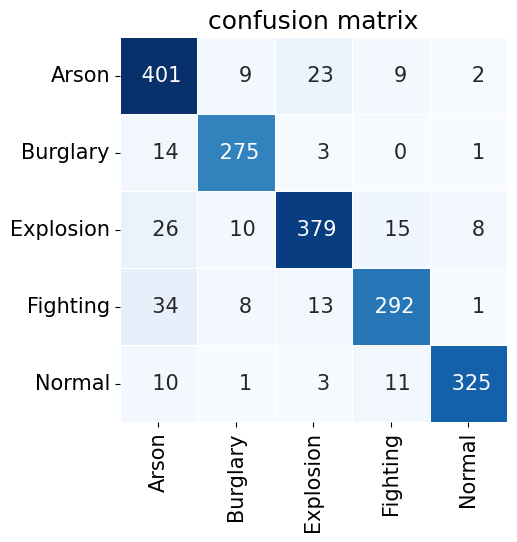

In [24]:
plt.figure(figsize=(5,5))
plt.rcParams['font.size']=15
sns.heatmap(
    data=confusion_matrix(y_true=actual, y_pred=pred),
    annot=True,
    fmt='4d',
    cbar=False,
    xticklabels=class_labels,
    yticklabels=class_labels,
    cmap=plt.cm.Blues,
    linewidths=0.5,
    linecolor='white'
)
plt.title(label='confusion matrix')
plt.show()

***model saving***

In [25]:
model.save("models/ConvolutionalNeuralNetwork_model.h5")